# Employee Retention

*Copied from challenge description:*
### Goal
Employee turnover is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

t is only natural then that data science has started being applied to this area. Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is sometimes called people analytics or people data science (if you see a job title: people data scientist, this is your job).

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.
### Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers
### Hints:
 - What are the main factors that drive employee churn? Do they make sense? Explain your findings.
 - What might you be able to do for the company to address employee Churn, what would be follow-up actions?
 - If you could add to this data set just one variable that could help explain employee churn, what would that be?
 - Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
empl = pd.read_csv('employee_retention_data.csv',low_memory=False)

In [3]:
empl.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
empl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


Change some datatypes.

In [5]:
empl.at[:,'employee_id'] = empl.employee_id.astype('int')
empl.at[:,'join_date'] = pd.to_datetime(empl.join_date)
empl.at[:,'quit_date'] = pd.to_datetime(empl.quit_date,errors='coerce')

print(empl.join_date.max(), empl.join_date.min(), empl.quit_date.max(),empl.quit_date.min())

2015-12-10 00:00:00 2011-01-24 00:00:00 2015-12-09 00:00:00 2011-10-13 00:00:00


In [6]:
empl.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [7]:
# note -- 99 years of seniority don't make sense, have a closer look at this:

empl[empl.seniority>30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [8]:
# Can savely assume this is a data error. 
# Since we have no information to update seniority, I'll drop these two columns for now

empl = empl[empl.seniority<=30]
empl.describe()

,employee_id,company_id,seniority,salary
count,24700.000000,24700.000000,24700.000000,24700.000000
mean,501616.624899,3.426802,14.120972,138176.275304
std,288908.533280,2.699752,8.054137,76056.331953
min,36.000000,1.000000,1.000000,17000.000000
25%,250165.250000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753142.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,29.000000,408000.000000


Compute # days before employee quits. Will be NaT if employee is still at the company. 
Then turn timedelta object into # of days, using dt.days attribute.

In [9]:
empl.loc[:,'days_before_quit'] = empl.quit_date-empl.join_date
empl.at[:,'days_before_quit'] = empl.days_before_quit.dt.days
empl.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days_before_quit
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


In [10]:
empl.days_before_quit.isnull().value_counts()

False    13508
True     11192
Name: days_before_quit, dtype: int64

We have a pretty even split between people who have quit and those who haven't at this point. The number of days before quitting would be our target variable for regression. We need to know how to treat the NaN's that represent not having quit yet though.

I will first do a classification to predict whether an employee is going to quit or not. Then I might run a regression only for those who are predicted to quit?

To get started with classificiation, and also for purposes of exploratory data analysis, we get
  - a column of T/F if quit or not
  - a column of how long ago employee joined --> int value
  - dummies for department (after EDA)

In [11]:
empl.loc[:,'quit'] = ~empl.days_before_quit.isnull()
empl.at[:,'quit'] = empl.loc[:,'quit'].astype('int')
empl.loc[:,'joined_days_ago'] = (empl.join_date.max()-empl.join_date).dt.days

### EDA

Now that we have some nicely prepared variables, let's look at some plots. Let's start by looking at days before quitting, our potential regression target.

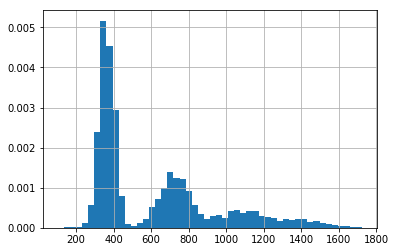

In [12]:
_= empl.days_before_quit.hist(bins=50, density=True)

**Interesting distribution!** And pretty skewed.

*Notably*:
 - large number of people quits within the first 14 months or so
 - then another spike around 2 years

Some of this data can likely be explained by the fact that we are cutting off in time so it makes sense that we will have less information about people who quit later on and capture more people who quit after a short period of time. *It would be very interesting to have data for a longer period of time to see how this affects these quit numbers.*

We now check how many people started when, to see if we also have skewed join_date information...


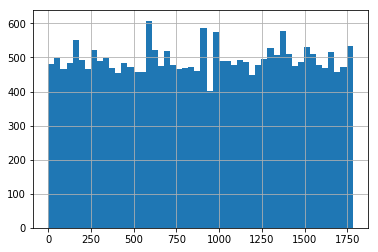

In [13]:
_= empl.joined_days_ago.hist(bins=50)

Join dates are distributed quite uniformly, so in terms of join date we have quite well-distributed data. What about split by quit or not? We plot histrograms for the separate groups.

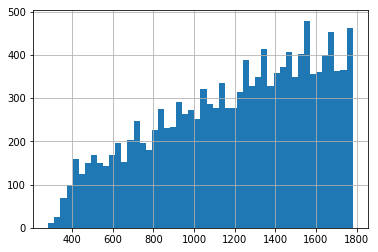

In [14]:
_= empl[empl.quit==True].joined_days_ago.hist(bins=50)

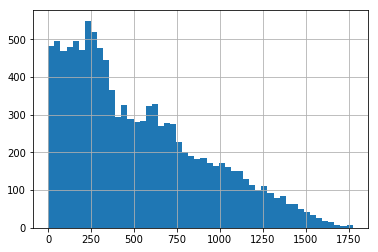

In [15]:
_= empl[empl.quit==False].joined_days_ago.hist(bins=50)

It appears that most of the employees who joined longer ago (more than two years before end of collection period, that is roughly before 2013) have quit by the end of 2015.  So overall, the longer you've been around, the more likely you are to quit. That is not too surprising?

Let's look at seniority next...

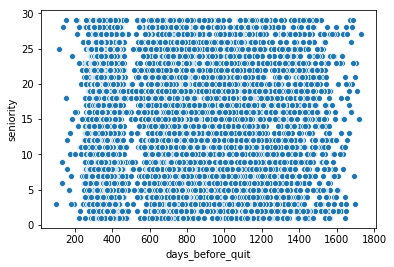

In [16]:
_=sns.scatterplot(x='days_before_quit',y='seniority', data=empl)

We have no striking correlation apparent here. But, we see that clear gap around 500 days before quitting...

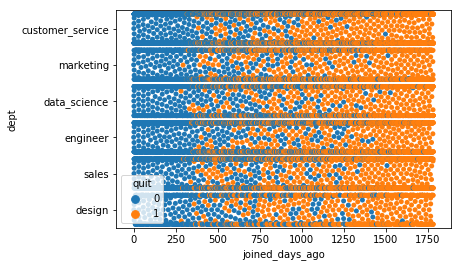

In [17]:
_=sns.swarmplot(y='dept',x='joined_days_ago', hue='quit', data=empl)

It looks like there's no significant difference across departments... this is supported by looking at the statistics:

In [18]:
empl[['quit','dept']].groupby(['dept']).describe() 

quit                                             
                   count      mean       std  min  25%  50%  75%  max
dept                                                                 
customer_service  9180.0  0.554902  0.497004  0.0  0.0  1.0  1.0  1.0
data_science      3190.0  0.527273  0.499334  0.0  0.0  1.0  1.0  1.0
design            1380.0  0.563768  0.496097  0.0  0.0  1.0  1.0  1.0
engineer          4612.0  0.511925  0.499912  0.0  0.0  1.0  1.0  1.0
marketing         3166.0  0.562855  0.496112  0.0  0.0  1.0  1.0  1.0
sales             3172.0  0.570933  0.495021  0.0  0.0  1.0  1.0  1.0

What about the different companies?

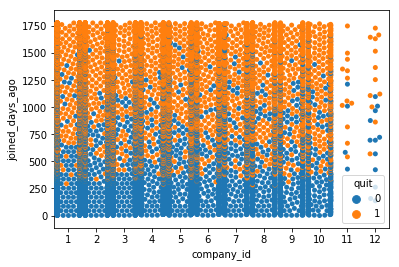

In [55]:
_=sns.swarmplot(x='company_id',y='joined_days_ago', hue='quit', data=empl)

In [20]:
empl[['quit','company_id']].groupby(['company_id']).describe() 

quit                                              
             count      mean       std  min   25%  50%  75%  max
company_id                                                      
1           8485.0  0.544490  0.498046  0.0  0.00  1.0  1.0  1.0
2           4222.0  0.522501  0.499553  0.0  0.00  1.0  1.0  1.0
3           2749.0  0.556930  0.496839  0.0  0.00  1.0  1.0  1.0
4           2062.0  0.559166  0.496607  0.0  0.00  1.0  1.0  1.0
5           1755.0  0.560114  0.496515  0.0  0.00  1.0  1.0  1.0
6           1291.0  0.551510  0.497532  0.0  0.00  1.0  1.0  1.0
7           1224.0  0.565359  0.495912  0.0  0.00  1.0  1.0  1.0
8           1047.0  0.553009  0.497420  0.0  0.00  1.0  1.0  1.0
9            961.0  0.550468  0.497705  0.0  0.00  1.0  1.0  1.0
10           864.0  0.554398  0.497320  0.0  0.00  1.0  1.0  1.0
11            16.0  0.750000  0.447214  0.0  0.75  1.0  1.0  1.0
12            24.0  0.500000  0.510754  0.0  0.00  0.5  1.0  1.0

...for the companies for which we have a lot of data, the statistics appear quite similar overall; analogous to what we observed for departments.

Now let's start with classification.

## Classification - will a given employee quit or not?

In [56]:
# get dummy variables for the departments 
dept_dummies = pd.get_dummies(empl.loc[:,'dept'])
empl_dummies = empl.join(dept_dummies)

In [23]:
X_empl = empl_dummies.drop(['quit_date','days_before_quit','quit','dept','join_date'],axis=1)
y_empl = empl.loc[:,['quit','days_before_quit']].astype('float')
y_empl.at[:,'quit'] = y_empl.quit.astype('int')
X_empl.head()

,employee_id,company_id,seniority,salary,joined_days_ago,customer_service,data_science,design,engineer,marketing,sales
0,13021,7,28,89000.0,626,1,0,0,0,0,0
1,825355,7,20,183000.0,955,0,0,0,0,1,0
2,927315,4,14,101000.0,423,0,0,0,0,1,0
3,662910,7,20,115000.0,1305,1,0,0,0,0,0
4,256971,2,23,276000.0,1515,0,1,0,0,0,0


We train a random forest classifier, to also get a look at feature importances.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train2, y_test2 = train_test_split(X_empl,y_empl,test_size=0.2)

y_train = y_train2.iloc[:,0] #first column is labels for classification. second column, those for regression.
y_test = y_test2.iloc[:,0]

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [28]:
y_pred_train = rf.predict(X_train)

acc = accuracy_score(y_train,y_pred_train)
c = confusion_matrix(y_train,y_pred_train)
f1 = f1_score(y_train,y_pred_train)
prec = precision_score(y_train,y_pred_train)
rec = recall_score(y_train,y_pred_train)

In [29]:
print('Performance on the training set: ')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Performance on the training set: 
Accuracy:  0.9904858299595142
Precision:  0.9937610578266133
Recall:  0.9887890299268044
F1 score:  0.9912688092141928
Confusion matrix:
[[ 8900    67]
 [  121 10672]]


In [30]:
acc = accuracy_score(y_test,y_pred_rf)
c = confusion_matrix(y_test,y_pred_rf)
f1 = f1_score(y_test,y_pred_rf)
prec = precision_score(y_test,y_pred_rf)
rec = recall_score(y_test,y_pred_rf)

In [31]:
print('Performance on the test set: ')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Performance on the test set: 
Accuracy:  0.771255060728745
Precision:  0.7929759704251387
Recall:  0.7900552486187845
F1 score:  0.7915129151291513
Confusion matrix:
[[1665  560]
 [ 570 2145]]


The untuned RF is doing great on the training set (overfit?!!), and decently on the test set. Let's have a look at the feature importances to see which of the features had the greatest impact on the classification.

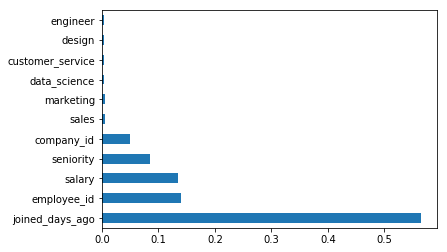

In [32]:
importance = rf.feature_importances_
features = X_train.columns
feat_imp = pd.DataFrame(list(zip(features,importance)), columns=['feature','importance'])
feat_imp = feat_imp.sort_values('importance',ascending=False)
ax = feat_imp.importance.plot(kind='barh')
_ = ax.set_yticklabels(feat_imp.feature.values)
#feat_imp

Joined days ago is by far the most crucial feature for predicting whether someone quit or not, that is in line with what we expected from the EDA.

Employee ID is seen as relatively important, and it's just an internal number... I'll remove that feature and see how it impacts the classifier...

In [33]:
X_train = X_train.drop('employee_id',axis=1)
X_test = X_test.drop('employee_id',axis=1)

rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

In [34]:
y_pred_train = rf.predict(X_train)

acc = accuracy_score(y_train,y_pred_train)
c = confusion_matrix(y_train,y_pred_train)
f1 = f1_score(y_train,y_pred_train)
prec = precision_score(y_train,y_pred_train)
rec = recall_score(y_train,y_pred_train)
print('Training set:')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Training set:
Accuracy:  0.9877024291497976
Precision:  0.9909717051377513
Recall:  0.9864727137959789
F1 score:  0.9887170915169244
Confusion matrix:
[[ 8870    97]
 [  146 10647]]


In [35]:
acc = accuracy_score(y_test,y_pred_rf)
c = confusion_matrix(y_test,y_pred_rf)
f1 = f1_score(y_test,y_pred_rf)
prec = precision_score(y_test,y_pred_rf)
rec = recall_score(y_test,y_pred_rf)

print('Test set:')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Test set:
Accuracy:  0.7615384615384615
Precision:  0.7866467735919433
Recall:  0.7767955801104972
F1 score:  0.7816901408450705
Confusion matrix:
[[1653  572]
 [ 606 2109]]


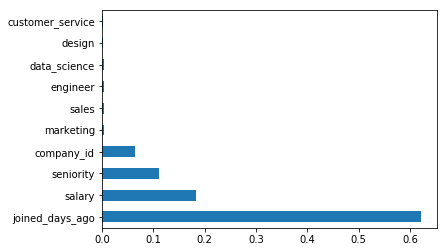

In [36]:
importance = rf.feature_importances_
features = X_train.columns
feat_imp = pd.DataFrame(list(zip(features,importance)), columns=['feature','importance'])
feat_imp = feat_imp.sort_values('importance',ascending=False)
ax = feat_imp.importance.plot(kind='barh')
_ = ax.set_yticklabels(feat_imp.feature.values)
#feat_imp

Result actually got a little worse... Let's do some parameter tuning to try to combat overfitting. I'll be using randomized search cross validation.

In [41]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()

X_train, X_test, y_train2, y_test2 = train_test_split(X_empl,y_empl,test_size=0.2)
y_train = y_train2.iloc[:,0] #first column is labels for classification. second column, those for regression.
y_test = y_test2.iloc[:,0]


# specify parameters and distributions to sample from
param_dist = {"n_estimators":[20,50],
              #"max_depth": [3, None],
              "max_features": sp_randint(1, 5), 
              "min_samples_split": sp_randint(2, 11), 
              "min_samples_leaf": sp_randint(1, 11),
              #"bootstrap": [True, False]
             }

# run randomized search
n_iter_search = 12
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

random_search.fit(X_train, y_train)
random_search.best_params_

{'max_features': 1,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 50}

{'max_features': 4,
 'min_samples_leaf': 10,
 'min_samples_split': 6,
 'n_estimators': 50}

In [42]:
tunedrf = random_search.best_estimator_
y_pred_tuned = tunedrf.predict(X_train)

acc = accuracy_score(y_train,y_pred_tuned)
c = confusion_matrix(y_train,y_pred_tuned)
f1 = f1_score(y_train,y_pred_tuned)
prec = precision_score(y_train,y_pred_tuned)
rec = recall_score(y_train,y_pred_tuned)

print('Training results:')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Training results:
Accuracy:  0.8459008097165992
Precision:  0.833233507315821
Recall:  0.8988369946464833
F1 score:  0.8647928599973358
Confusion matrix:
[[6977 1949]
 [1096 9738]]


In [43]:
y_pred_tuned = tunedrf.predict(X_test)

acc = accuracy_score(y_test,y_pred_tuned)
c = confusion_matrix(y_test,y_pred_tuned)
f1 = f1_score(y_test,y_pred_tuned)
prec = precision_score(y_test,y_pred_tuned)
rec = recall_score(y_test,y_pred_tuned)

print('Test results:')
print('Accuracy: ',acc)
print('Precision: ',prec)
print('Recall: ',rec)
print('F1 score: ',f1)
print('Confusion matrix:')
print(c)

Test results:
Accuracy:  0.7975708502024291
Precision:  0.7886206896551724
Recall:  0.8552729992520568
F1 score:  0.8205956225331897
Confusion matrix:
[[1653  613]
 [ 387 2287]]


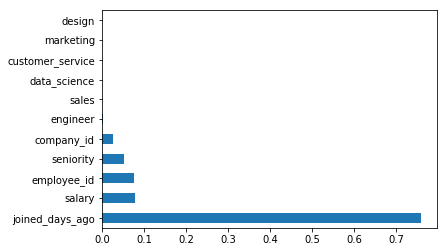

In [44]:
importance = tunedrf.feature_importances_
features = X_train.columns
feat_imp = pd.DataFrame(list(zip(features,importance)), columns=['feature','importance'])
feat_imp = feat_imp.sort_values('importance',ascending=False)
ax = feat_imp.importance.plot(kind='barh')
_ = ax.set_yticklabels(feat_imp.feature.values)

After tuning, train and test results are closer together (and test results have improved by 2-3%), so the tuning improved a little against overfitting. The variable `joined_days_ago` is now by far the most important feature. 

### Conclusion after classification.

It appears that how long someone has been at a company is the most important predictor for whether they will leave. Other important factors are salary and seniority.

Based on the EDA, there seem to be 3 groups of leaving:
- after just over one year
- after around two years
- later than that

In view of this, if I could obtain more data, I would love to see:
- data from a longer time interval
- career advancement info? when have people been promoted...? This could help to inform and distinguish the different groups when leaving.


### Regression on the predicted quits?

Now we'll try to predict time until quitting for the people who have been classified as quit=True.
- subset dataframe and 'quit_days_ago' by predicted quits
- train a regressor on training subset of that

In [45]:
y_tr = y_train2.iloc[:,1]
y_te = y_test2.iloc[:,1]

X_tr_reg = X_train[~y_tr.isnull()]
y_tr = y_tr[~y_tr.isnull()]

X_te_reg = X_test[~y_te.isnull()]
y_te = y_te[~y_te.isnull()]


In [46]:
print(y_tr.shape, y_te.shape)

(10834,) (2674,)


In [47]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(X_tr_reg,y_tr)
y_pred_reg = rfr.predict(X_tr_reg)

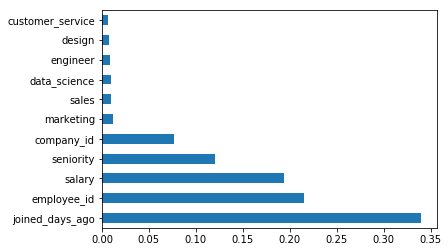

In [48]:
importance = rfr.feature_importances_
features = X_tr_reg.columns
feat_imp = pd.DataFrame(list(zip(features,importance)), columns=['feature','importance'])
feat_imp = feat_imp.sort_values('importance',ascending=False)
ax = feat_imp.importance.plot(kind='barh')
_ = ax.set_yticklabels(feat_imp.feature.values)

In [49]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

In [50]:
mse = mean_squared_error(y_tr,y_pred_reg)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_tr,y_pred_reg)
mae = mean_absolute_error(y_tr,y_pred_reg)
r2 = r2_score(y_tr,y_pred_reg)
print('Metrics on training set:')
print('RMSE: {}'.format(rmse))
print('MSLE: ', msle)
print('MAE: ', mae)
print('R^2: ', r2)

Metrics on training set:
RMSE: 131.6420999499478
MSLE:  0.04772290160168702
MAE:  93.77240169835702
R^2:  0.8403426141989575


In [51]:
y_pred_reg_test = rfr.predict(X_te_reg)

mse = mean_squared_error(y_te,y_pred_reg_test)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_te,y_pred_reg_test)
mae = mean_absolute_error(y_te,y_pred_reg_test)
r2 = r2_score(y_te,y_pred_reg_test)
print('Metrics on test set:')
print('RMSE: {}'.format(rmse))
print('MSLE: ', msle)
print('MAE: ', mae)
print('R^2: ', r2)

Metrics on test set:
RMSE: 311.1008137507518
MSLE:  0.22659219965118765
MAE:  240.77483171278985
R^2:  0.08402440825969504


The prediction is typically off by 3-4 months in the training set, and by more than 8 months in the test set. Let's look at the rough distribution of actual target values and predictions. On the training set:

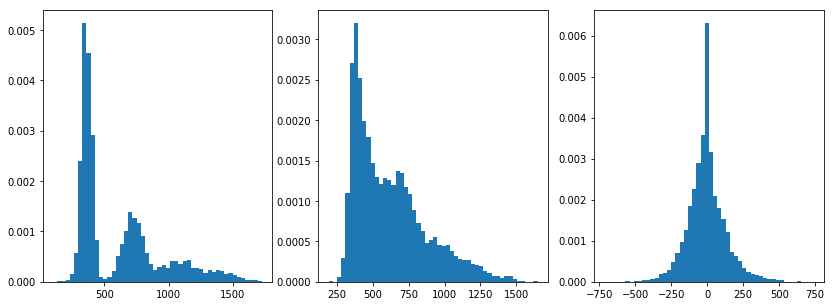

In [52]:
plt.figure(figsize=(14, 5))
plt.subplot(1,3,1)
plt.hist(y_tr, bins =50, density=True)

y_pred_tr = rfr.predict(X_tr_reg)
plt.subplot(1,3,2)
plt.hist(y_pred_tr, bins =50, density=True)

plt.subplot(1,3,3)
_ = plt.hist(y_tr-y_pred_tr, bins =50, density=True)

And on the test set:

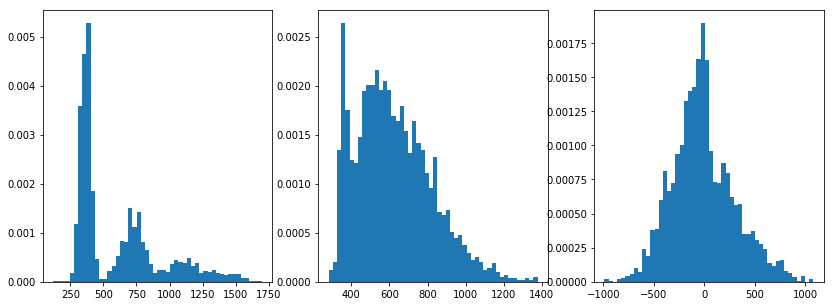

In [53]:
plt.figure(figsize=(14, 5))
plt.subplot(1,3,1)
plt.hist(y_te, bins =50, density=True)

y_pred_te = rfr.predict(X_te_reg)
plt.subplot(1,3,2)
plt.hist(y_pred_te, bins =50, density=True)

plt.subplot(1,3,3)
_ = plt.hist(y_te-y_pred_te, bins =50, density=True)

We see that the multimodality of the distribution is not resolved very well. I would say that more information about the different groups of quitters is needed, to be able to better distinguish among them.


Based on my observations, I would suggest to the company to group their employees roughly by how long they have been at the company and collect more data (for example about internal promotions) about these groups to better understand churn, since I would hypothesize that different motivators play into leaving at different times and the current amount of information doesn't allow to resolve these groups.

It was possible to predict whether an employee would quit or not reasonably well, so this information can allow the company to target at-risk employees and try to improve their satisfaction with their job, to keep them at the company.